# Spectrogram data preparation

Aim: create a pipeline which creates a dataset of (spectrogram, caption) pairs

1. Load from huggingface
2. Inspect data
3. Prepare dataset of first speaker


In [28]:
import torchaudio
import librosa
import librosa.display
import numpy as np
from torchaudio.transforms import Spectrogram
from torchvision.transforms import functional as tf
import matplotlib.pyplot as plt

In [ ]:
# Check available datasetes

from datasets import load_dataset, list_datasets

""" dataset_lists = list_datasets()

print(', '.join(dataset for dataset in dataset_lists)) """

In [11]:
dataset = load_dataset('lj_speech', split='train')

Found cached dataset lj_speech (/home/ryan/.cache/huggingface/datasets/lj_speech/main/1.1.0/6e03b5308ab68705d902e2bbeaff59feb283307770fafb8d6704e604b6d179aa)


In [14]:
print(dataset)
dataset[0]

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 13100
})


{'id': 'LJ001-0001',
 'audio': {'path': '/home/ryan/.cache/huggingface/datasets/downloads/extracted/767c76e13c24c1cc26025e0fbcf1d4fe53cfaa6521aac12a67eac69b9fa07ab2/LJSpeech-1.1/wavs/LJ001-0001.wav',
  'array': array([-7.32421875e-04, -7.62939453e-04, -6.40869141e-04, ...,
          7.32421875e-04,  2.13623047e-04,  6.10351562e-05]),
  'sampling_rate': 22050},
 'file': '/home/ryan/.cache/huggingface/datasets/downloads/extracted/767c76e13c24c1cc26025e0fbcf1d4fe53cfaa6521aac12a67eac69b9fa07ab2/LJSpeech-1.1/wavs/LJ001-0001.wav',
 'text': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 'normalized_text': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'}

In [15]:
# separate dataset to only LJ001 for initial experiments

lj1 =  dataset.filter(lambda example: example["id"].startswith("LJ001"))

print(lj1)


Filter:   0%|          | 0/13100 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 186
})


In [16]:
lj1.save_to_disk("/home/ryan/diss/msc_diss/sdspeech/data/training/audio/speech/LJSpeech/LJ1")

Saving the dataset (0/1 shards):   0%|          | 0/186 [00:00<?, ? examples/s]

In [ ]:
import librosa

# Convert .wav to spectrograms
# Experiment with one

In [ ]:
import torchaudio
from torchaudio.transforms import Spectrogram
from torchvision.transforms import functional as tf

def transform_wav(dataset, transform):
    for data in dataset:
        waveform, sr = librosa.load(data['audio']['path'])
    
        mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr)

        # Convert to decibels (log scale)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        
    
    

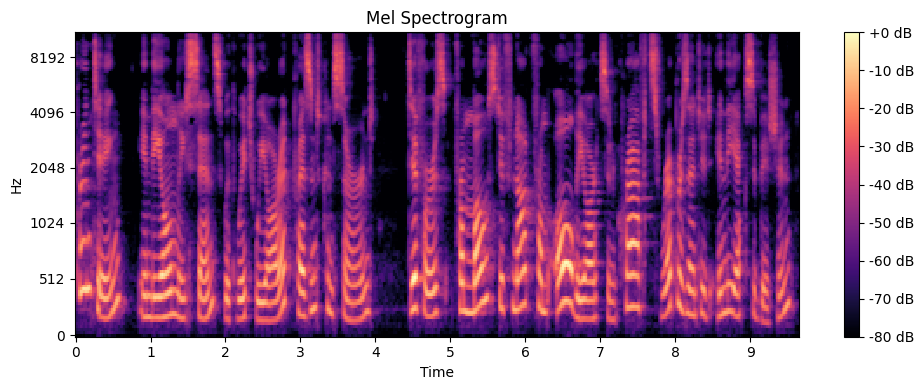

In [27]:
import torchaudio
import librosa
import librosa.display
import numpy as np
from torchaudio.transforms import Spectrogram
from torchvision.transforms import functional as tf
import matplotlib.pyplot as plt

# Load data
lj1_ex = lj1[0]

# Convert to mel spec
waveform, sr = librosa.load(lj1_ex['audio']['path'])
mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr)

# Convert to decibels (log scale)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Display the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()